In [ ]:
# Danila Valko
# May 2024

### setup

In [ ]:
import os, sys, time, pickle, datetime, random, json, glob
from tqdm import tqdm, notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from scipy.stats import pearsonr, spearmanr
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import ScalarFormatter
import warnings
warnings.filterwarnings("ignore")
sfmt = StrMethodFormatter('{x:,.2f}')
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0,0))

In [ ]:
!rm -rf eth-broadcast-protocol
!git clone https://github.com/ellariel/eth-broadcast-protocol.git

Cloning into 'eth-broadcast-protocol'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 170 (delta 66), reused 127 (delta 31), pack-reused 0
Receiving objects: 100% (170/170), 3.17 MiB | 5.03 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [ ]:
def get_stars(p, p001='***', p01='**', p05='*', p10=''):
    if p < 0.001:
        return p001
    if p < 0.010:
        return p01
    if p < 0.050:
        return p05
    if p < 0.100:
        return p10
    return ''

def print_stat(a, b):
    metrics = {0: 'averaged sync time',
               5: 'sync time',
               #1: 'averaged sync rate',
               #7: 'sync rate',
               4: 'fork rate',
               #3: 'msg/block',
               #2: 'msg',
               6: 'average blocks count',
               #8: 'sync blocks count',
               9: 'sync blocks rate',
               10: 'msg/sync block',}

    def print_metric(metric_idx, percent_points=False):
      r1, r2 = a[metric_idx], b[metric_idx]
      t, p = mannwhitneyu(r1, r2)
      d = (np.mean(r1)-np.mean(r2)) * 100
      if not percent_points:
        d = d / np.mean(r2)
      print(f"{metrics[metric_idx]+': ':<20}{np.mean(r1):.3f}({len(r1)}) <> {np.mean(r2):.3f}({len(r2)}), ε={'+' if d >=0 else ''}{d:.1f}%{'(pp)' if percent_points else ''}, U={t}, p={p:.3f}{get_stars(p)}")

    for k, v in metrics.items():
      print_metric(k, k in [1,7,9])

def get_statistics(result):
        n = len(result['nodes_list'])
        r = {'n': n,
             'msg_count': result['msg_counter'],
             'blocks_count': len(result['created_blocks']),
             'forks_count': np.sum([result[i] for i in result.keys() if 'forks' in i]),
             'sync_time': [np.max(v) - np.min(v) for k, v in result['block_propagation_final'].items() if len(v) >= n // 2],
             'sync_rate': [len(v) / n for k, v in result['block_propagation_final'].items()],
             }
        r.update({'sync_blocks': len(r['sync_time'])})
        return r

def get_total_metrics(results, n=300):
    sync_time_ = []
    sync_time = []
    msg_count = []
    sync_rate = []
    sync_rate_ = []
    fork_rate = []
    msg_block = []
    block_count = []
    sync_blocks = []
    msg_sync_block = []
    for idx, r in enumerate(results):
          if idx >= n:
            break
          sync_time_ += r['sync_time']
          sync_time += [np.nanmean(r['sync_time'])]
          msg_count += [r['msg_count']]
          sync_rate_ += r['sync_rate']
          sync_rate += [np.nanmean(r['sync_rate'])]
          fork_rate += [r['forks_count'] / (r['blocks_count'] + r['forks_count'])]
          msg_block += [r['msg_count']/(r['blocks_count'] + r['forks_count'])]
          if r['sync_blocks'] > 0 and r['blocks_count'] > 0:
            block_count += [r['blocks_count']]
            sync_blocks += [r['sync_blocks']]
            msg_sync_block += [r['msg_count']/r['sync_blocks']]
    sync_time = [i for i in sync_time if not np.isnan(i)]
    sync_rate = [i for i in sync_rate if not np.isnan(i)]
    fork_rate = [i if not np.isnan(i) else 0 for i in fork_rate]
    sync_blocks_rate = np.array(sync_blocks) / np.array(block_count)
    return sync_time, sync_rate, msg_count, msg_block, fork_rate, sync_time_, block_count, sync_rate_, sync_blocks, sync_blocks_rate, msg_sync_block

def score_plots(log_data):
  def draw(ax, key, ylabel=False, xlabel=False, xlog=False):
      for e in env:
            data = log_data[log_data['version'] == e]
            if 'max_'+key in data and pd.notna(data['max_'+key]).all():
              _data = []
              for idx, d in data.iterrows():
                epoch = d['epoch']
                for k in d['mean_reward'][1:][:-1].split():
                  _data.append((epoch, float(k)))
              data = pd.DataFrame(_data).rename(columns={0:'epoch', 1:'max_mean_reward'})
              sns.lineplot(ax=ax, data=data, x='epoch', y='max_'+key, label=f' {e}')
            else:
              sns.lineplot(ax=ax, data=data, x='epoch', y=key, label=f' {e}')
      if not ylabel:
        ax.set_ylabel(key)
      else:
        ax.set_ylabel(ylabel)
      if xlog:
        ax.set(xscale='log')
      if xlabel:
        ax.set_xlabel(xlabel)
  env = log_data['version'].drop_duplicates()
  fig = plt.figure(figsize=(8,5))
  ax = fig.add_subplot(221)
  draw(ax, 'mean_reward', xlog=False, ylabel='average reward', xlabel='epochs')
  ax.set_xlim(left=1)
  fig.tight_layout()
  plt.show()

def print_reward(approach='PPO', env_type=''):
    logs = sorted(glob.glob(os.path.join(os.path.join(base_dir, 'results'), f'{approach}-{env_type}*.log')))
    logs = sorted(glob.glob(os.path.join(os.path.join(base_dir, 'results'), f'{approach}-{env_type}.log')))
    print(f'{len(logs)} logs detected')
    log_data = None
    for l in logs:
        try:
          r = pd.read_csv(l, sep=';', compression='zip')
        except:
          r = pd.read_csv(l, sep=';')
        r['time'] = r['time'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))
        r.sort_values(by='time', inplace=True)
        r['epoch_'] = r['epoch']
        r['epoch'] = r.index + 1
        log_data = pd.concat([log_data, r], ignore_index=True)
    score_plots(log_data)

def _lineplot(data, x='t', ylim=None, xlog=False,
             xlabel='simulation duration, sec',
             ylabel='averaged sync time, sec',
             color={'model':'green',
                    'random_sameseed':'salmon'},
             label={'model':'RLA',
                    'random_sameseed':'BPP'}):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(221)
    if ylim:
      ax.set_ylim(ylim)
    if xlog:
      ax.set_xscale('log')
    for k, v in label.items():
        sns.lineplot(ax=ax, data=data, x=x, color=color[k], y=k, label=v, errorbar='ci')
    leg = ax.legend()
    leg = {handle.get_label(): handle for handle in leg.legendHandles}
    for k, v in label.items():
      leg[v].set_color(color[k])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.tight_layout()
    plt.show()

def _ecdfplot(data, title='', x='t', xlim=None, log=False,
             xlabel='averaged sync time, sec',
             ylabel='ECDF',
             color={'model':'green',
                    'random_sameseed':'salmon'},
             label={'model':'RLA',
                    'random_sameseed':'BPP'}):
    data = data.copy()
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(221)
    if xlim:
      ax.set_xlim(xlim)
    for k, v in label.items():
        sns.ecdfplot(ax=ax, data=data, x=k, legend=True, log_scale=log, color=color[k], label=v)
    leg = ax.legend()
    leg = {handle.get_label(): handle for handle in leg.legendHandles}
    for k, v in label.items():
      leg[v].set_color(color[k])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

def _regplot(data, x='blocks', ylim=None, xlim=None, robust=True, order=1, xlog=False, ylog=False,
             xlabel='introduced blocks',
             ylabel='sync. time, sec',
             color={'model':'green',
                    'random_sameseed':'salmon'},
             label={'model':'RLA',
                    'random_sameseed':'BPP'}):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(221)
    if ylim:
      ax.set_ylim(ylim)
    if xlim:
      ax.set_xlim(xlim)
    if xlog:
      ax.set(xscale='log')
    if ylog:
      ax.set(yscale='log')
      ax.yaxis.set_major_formatter(xfmt)
    random.seed(13)
    np.random.seed(13)
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=ConvergenceWarning)
      for k, v in label.items():
        sns.regplot(ax=ax, data=data[k], x=x, y=k, label=label[k], y_jitter=0.0001, x_jitter=0.01, color=color[k], robust=robust,
            line_kws=dict(color=color[k],), order=order,
            scatter_kws=dict(s=25,
                             linewidth=0.01,
                             facecolors='none',
                             edgecolors='light'+color[k],))
    leg = ax.legend()
    leg = {handle.get_label(): handle for handle in leg.legendHandles}
    for k, v in label.items():
      leg[v].set_color(color[k])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.tight_layout()
    plt.show()

In [ ]:
base_dir = './eth-broadcast-protocol'
results_dir = os.path.join(base_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

### learning statistics

1 logs detected


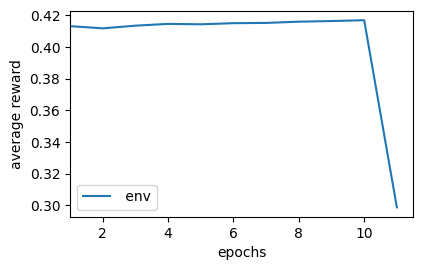

In [ ]:
print_reward(env_type='env*')

### statistics

In [ ]:
k = 1000
id = '442'
type = 'ethereum'
duration = 60
k_results = None
for i in range(k, 40, -50):
    if type:
      f = os.path.join(results_dir, f'k_results-{id}-{type}-{duration}-{i}.pickle')
    else:
      f = os.path.join(results_dir, f'k_results-{id}-{duration}-{i}.pickle')
    if os.path.exists(f):
      print(f)
      with open(f, 'rb') as f:
          k_results = pickle.load(f)
          k = i
      break
print(f"k: {k}, duration: {duration}, id: {id}{' - ok' if k_results else ' - no data!'}")
model_results = get_total_metrics(k_results['model'], k)
random_sameseed_results = get_total_metrics(k_results['random_sameseed'], k)
print(f'\nsame random seed (k={k}):  model <> random')
print_stat(model_results, random_sameseed_results)
pass

./eth-broadcast-protocol/results/k_results-442-ethereum-60-1000.pickle
k: 1000, duration: 60, id: 442 - ok

same random seed (k=1000):  model <> random
averaged sync time: 1.834(1000) <> 1.866(1000), ε=-1.7%, U=382917.0, p=0.000***
sync time:          1.836(3410) <> 1.873(3236), ε=-2.0%, U=5206578.0, p=0.000***
fork rate:          0.000(1000) <> 0.000(1000), ε=nan%, U=500000.0, p=1.000
average blocks count: 3.529(1000) <> 3.412(1000), ε=+3.4%, U=558500.0, p=0.000***
sync blocks rate:   0.970(1000) <> 0.951(1000), ε=+1.9%(pp), U=532010.5, p=0.000***
msg/sync block:     9272.930(1000) <> 9758.055(1000), ε=-5.0%, U=425388.0, p=0.000***


k:1000, duration: 60, id:442, ok


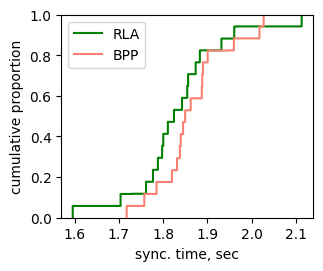

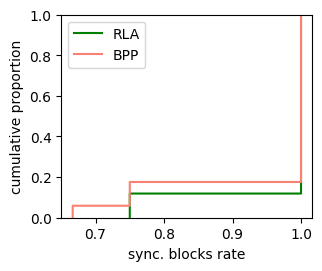

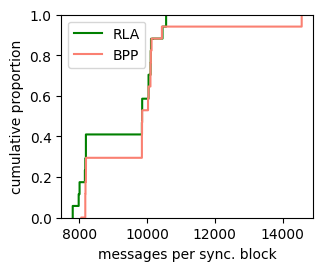

In [ ]:
print(f"k:{k}, duration: {duration}, id:{id}{', ok' if k_results else ''}")
_ecdfplot({'model':model_results[0],
           'random_sameseed':random_sameseed_results[0]}, xlabel='sync. time, sec', ylabel='cumulative proportion')
_ecdfplot({'model':model_results[9],
           'random_sameseed':random_sameseed_results[9]}, xlabel='sync. blocks rate', ylabel='cumulative proportion')
_ecdfplot({'model':model_results[10],
           'random_sameseed':random_sameseed_results[10]}, xlabel='messages per sync. block', ylabel='cumulative proportion')

k:1000, duration: 60, id:442, ok
n=500500


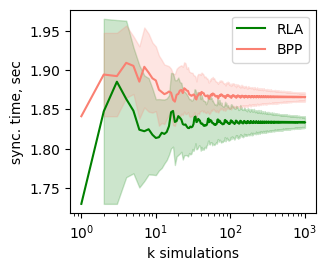

n=500500


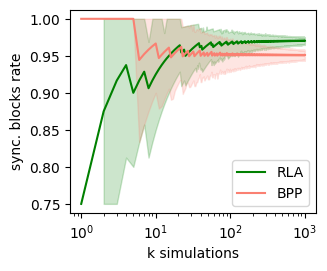

n=500500


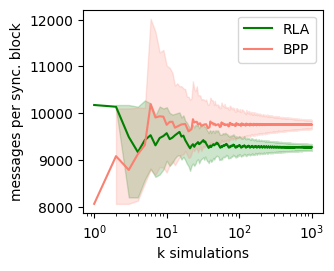

In [ ]:
print(f"k:{k}, duration: {duration}, id:{id}{', ok' if k_results else ''}")
avg_sync_time = []
avg_sync_rate = []
avg_msg_rate = []
for n in range(1, k + 1):
    m = get_total_metrics(k_results['model'], n)
    rs = get_total_metrics(k_results['random_sameseed'], n)
    avg_sync_time += [(n, i, s) for i, s in zip(m[0], rs[0])]
    avg_sync_rate += [(n, i, s) for i, s in zip(m[9], rs[9])]
    avg_msg_rate += [(n, i, s) for i, s in zip(m[10], rs[10])]

data = pd.DataFrame(avg_sync_time).rename(columns={0: 'k', 1: 'model', 2: 'random_sameseed'})
print(f'n={len(data)}')
_lineplot(data=data, x='k', xlog=True, ylabel='sync. time, sec', xlabel='k simulations')

data = pd.DataFrame(avg_sync_rate).rename(columns={0: 'k', 1: 'model', 2: 'random_sameseed'})
print(f'n={len(data)}')
_lineplot(data=data, x='k', xlog=True, ylabel='sync. blocks rate', xlabel='k simulations')

data = pd.DataFrame(avg_msg_rate).rename(columns={0: 'k', 1: 'model', 2: 'random_sameseed'})
print(f'n={len(data)}')
_lineplot(data=data, x='k', xlog=True, ylabel='messages per sync. block', xlabel='k simulations')